In [25]:
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
# import pandas as pd # already imported
import csv
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from scipy import signal # For resampling

# from sklearn.datasets import fetch_mldata # Deprecated
import seaborn as sns
import sklearn as sklearn
from sklearn.neighbors import KNeighborsClassifier
import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, classification_report

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
import graphviz
import statsmodels.api as sm
from sklearn import tree
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler # Alternative to manual normalization

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import RFE

In [27]:
# --- Configuration & Data Loading ---
data_set_path = 'C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\WESAD\\'
s2_path = data_set_path + 'S2/S2.pkl'

# Load data for Subject S2
with open(s2_path, 'rb') as file:
    s2_data = pickle.load(file, encoding='latin1')
print("S2 data loaded.")

# Extract labels (common for all feature sets)
raw_labels = s2_data['label']
print("Raw label shape:", raw_labels.shape)

# Ensure labels is a flat 1-D array
labels = np.squeeze(raw_labels)
print("Squeezed label shape:", labels.shape)

# Now you can safely get the length
target_len = len(labels)
print("Target length:", target_len)

S2 data loaded.
Raw label shape: (4255300,)
Squeezed label shape: (4255300,)
Target length: 4255300


In [28]:
# --- Feature Extraction and Preparation ---

# Chest features
c_ax = s2_data['signal']['chest']['ACC'][:, 0]
c_ay = s2_data['signal']['chest']['ACC'][:, 1]
c_az = s2_data['signal']['chest']['ACC'][:, 2]
c_ecg = s2_data['signal']['chest']['ECG'][:, 0]
c_emg = s2_data['signal']['chest']['EMG'][:, 0]
c_eda = s2_data['signal']['chest']['EDA'][:, 0]
c_temp = s2_data['signal']['chest']['Temp'][:, 0]
c_resp = s2_data['signal']['chest']['Resp'][:, 0]

df_chest = pd.DataFrame({
    "c_ax": c_ax, "c_ay": c_ay, "c_az": c_az,
    "c_ecg": c_ecg, "c_emg": c_emg, "c_eda": c_eda,
    "c_temp": c_temp, "c_resp": c_resp,
    "label": labels
})
print("Chest DataFrame created. Shape:", df_chest.shape)

# Wrist features
w_acc_x = s2_data['signal']['wrist']['ACC'][:, 0]
w_acc_y = s2_data['signal']['wrist']['ACC'][:, 1]
w_acc_z = s2_data['signal']['wrist']['ACC'][:, 2]
w_bvp = s2_data['signal']['wrist']['BVP'][:, 0]
w_eda = s2_data['signal']['wrist']['EDA'][:, 0]
w_temp = s2_data['signal']['wrist']['TEMP'][:, 0]

# Resample wrist features to match the target length (length of labels)
w_ax_resampled = signal.resample(w_acc_x, target_len)
w_ay_resampled = signal.resample(w_acc_y, target_len)
w_az_resampled = signal.resample(w_acc_z, target_len)
w_bvp_resampled = signal.resample(w_bvp, target_len)
w_eda_resampled = signal.resample(w_eda, target_len)
w_temp_resampled = signal.resample(w_temp, target_len)

df_wrist = pd.DataFrame({
    "w_ax": w_ax_resampled, "w_ay": w_ay_resampled, "w_az": w_az_resampled,
    "w_bvp": w_bvp_resampled, "w_eda": w_eda_resampled, "w_temp": w_temp_resampled,
    "label": labels
})
print("Wrist DataFrame created (after resampling). Shape:", df_wrist.shape)

# Combined features (Chest + Wrist)
df_combined = pd.DataFrame({
    "c_ax": c_ax, "c_ay": c_ay, "c_az": c_az,
    "c_ecg": c_ecg, "c_emg": c_emg, "c_eda": c_eda,
    "c_temp": c_temp, "c_resp": c_resp,
    "w_ax": w_ax_resampled, "w_ay": w_ay_resampled, "w_az": w_az_resampled,
    "w_bvp": w_bvp_resampled, "w_wrist_eda": w_eda_resampled, # Renamed to avoid clash with c_eda if selected
    "w_temp": w_temp_resampled,
    "label": labels
})
print("Combined DataFrame created. Shape:", df_combined.shape)


Chest DataFrame created. Shape: (4255300, 9)
Wrist DataFrame created (after resampling). Shape: (4255300, 7)
Combined DataFrame created. Shape: (4255300, 15)


In [29]:
# --- Preprocessing Function ---
def preprocess_data(df_input, label_column='label'):
    """
    Performs outlier removal and mean normalization.
    Returns processed X, y for train/test split and for cross-validation.
    """
    print(f"\nPreprocessing data for DataFrame with shape: {df_input.shape}")
    display(df_input.info())
    display(df_input.describe())

    # Separate features and labels
    X = df_input.drop(label_column, axis=1)
    y = df_input[label_column]

    # Outlier removal using IQR
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    # print("IQR is\n", IQR) # Can be verbose
    
    outlier_condition = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
    X_out = X[outlier_condition]
    y_out = y[outlier_condition]
    
    print(f"Shape after outlier removal: X_out: {X_out.shape}, y_out: {y_out.shape}")
    
    if X_out.empty or y_out.empty:
        print("Warning: All data removed after outlier handling. Check data or outlier thresholds.")
        # Return empty DataFrames/Series to avoid errors, or handle appropriately
        empty_df = pd.DataFrame()
        empty_series = pd.Series(dtype='float64') # Match dtype if possible
        return empty_df, empty_series, empty_df, empty_series, empty_df, empty_series


    # Mean normalization (StandardScaler is also a good option: StandardScaler().fit_transform(X_out))
    X_norm = (X_out - X_out.mean()) / X_out.std()
    y_norm_labels = y_out # Labels are not normalized

    # Handle cases where std might be zero after outlier removal for some columns
    X_norm.fillna(0, inplace=True) # Replace NaNs (from 0/0) with 0

    print("Normalization complete.")
    display(X_norm.head())
    display(X_norm.describe())

    # Split data for traditional train/test
    X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(
        X_norm, y_norm_labels, test_size=0.2, random_state=42, stratify=y_norm_labels if y_norm_labels.nunique() > 1 else None
    )
    
    return X_train_norm, X_test_norm, y_train_norm, y_test_norm, X_norm, y_norm_labels


In [30]:
# --- Modeling Function ---
def train_and_evaluate_models(X_train, X_test, y_train, y_test, X_full_norm, y_full_norm, title_prefix=""):
    """
    Trains a few selected models and prints classification reports.
    Uses train/test split for some, and cross-validation on full data for others.
    """
    print(f"\n--- {title_prefix} Model Evaluation ---")

    # --- QDA ---
    print("\n--- QDA (on train/test split) ---")
    try:
        qda_clf = QuadraticDiscriminantAnalysis()
        qda_clf.fit(X_train, y_train)
        y_out_qda = qda_clf.predict(X_test)
        print(classification_report(y_test, y_out_qda, digits=4, zero_division=0))
    except Exception as e:
        print(f"QDA failed: {e}")

    print("\n--- QDA (with 3-fold Cross-Validation on all normalized data) ---")
    try:
        qda_cv_clf = QuadraticDiscriminantAnalysis()
        # Ensure y_full_norm is 1D array of integers/strings for stratification
        y_pred_qda_cv = cross_val_predict(qda_cv_clf, X_full_norm, y_full_norm, cv=3)
        print(classification_report(y_full_norm, y_pred_qda_cv, digits=4, zero_division=0))
    except Exception as e:
        print(f"QDA with CV failed: {e}")

    # --- XGBoost ---
    print("\n--- XGBoost (on train/test split) ---")
    # Note: XGBoost can handle NaNs if present, but data is normalized here.
    # Ensure labels are 0 to num_classes-1 if objective is 'multi:softmax'
    # For WESAD, labels are 0,1,2,3,4,5,6,7. If 0 is not active, mapping might be needed.
    # Let's assume labels are fine for now. Max label in WESAD S2 is 7.
    # num_class should be max_label + 1 if labels start from 0.
    # For the WESAD paper, labels are: 0=not defined/transient, 1=baseline, 2=stress, 3=amusement, 4=meditation
    # The provided code uses labels 0,1,2,3,4. This is fine.
    
    # Check unique labels for num_class
    unique_labels = np.unique(y_train)
    num_classes = len(unique_labels) # If labels are 0,1,2,3, num_classes = 4
    # If labels are like [0,1,3,4], num_classes is still 4, but XGBoost needs 0..3 for multi:softmax
    # For safety, let's assume labels are dense starting from 0. WESAD labels 0,1,2,3,4 usually work directly.

    try:
        xg_class = xgb.XGBClassifier(objective='multi:softmax', 
                                     num_class=num_classes if num_classes > 1 else 2, # Handle binary case if it arises
                                     colsample_bytree=0.3, learning_rate=0.1,
                                     max_depth=5, alpha=10, n_estimators=50, gamma=10,
                                     use_label_encoder=False, eval_metric='mlogloss', random_state=42) # Added random_state
        
        xg_class.fit(X_train, y_train)
        y_out_xgb = xg_class.predict(X_test)
        print(classification_report(y_test, y_out_xgb, digits=4, zero_division=0))
    except Exception as e:
        print(f"XGBoost failed: {e}")

    # --- KNN (example, can be slow) ---
    print("\n--- KNN (k=5, with 3-fold Cross-Validation on all normalized data) ---")
    print("Note: KNN can be very slow on large datasets.")
    try:
        knn_clf = KNeighborsClassifier(n_neighbors=5)
        # Taking a smaller sample for KNN CV if X_full_norm is too large, for demonstration
        if len(X_full_norm) > 50000: # Arbitrary threshold for "large"
            print("Dataset for KNN CV is large, using a subsample of 50000 for speed.")
            # Stratified subsampling
            _, X_sample, _, y_sample = train_test_split(X_full_norm, y_full_norm, test_size=min(50000, len(X_full_norm)-1)/len(X_full_norm), stratify=y_full_norm, random_state=42)
        else:
            X_sample, y_sample = X_full_norm, y_full_norm

        if len(X_sample) > 1 : # Ensure sample is not empty
            y_pred_knn_cv = cross_val_predict(knn_clf, X_sample, y_sample, cv=min(3, X_sample.shape[0]-1 if X_sample.shape[0]>1 else 1)) # cv must be <= n_samples
            print(classification_report(y_sample, y_pred_knn_cv, digits=4, zero_division=0))
        else:
            print("Not enough samples for KNN CV after potential subsampling.")

    except Exception as e:
        print(f"KNN with CV failed: {e}")


In [31]:
# --- Process and Model Chest Data ---
X_train_c, X_test_c, y_train_c, y_test_c, X_norm_c, y_norm_c = preprocess_data(df_chest.copy())
if not X_norm_c.empty:
    train_and_evaluate_models(X_train_c, X_test_c, y_train_c, y_test_c, X_norm_c, y_norm_c, "Chest Features")
else:
    print("Skipping Chest Data modeling due to empty preprocessed data.")



Preprocessing data for DataFrame with shape: (4255300, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4255300 entries, 0 to 4255299
Data columns (total 9 columns):
 #   Column  Dtype  
---  ------  -----  
 0   c_ax    float64
 1   c_ay    float64
 2   c_az    float64
 3   c_ecg   float64
 4   c_emg   float64
 5   c_eda   float64
 6   c_temp  float32
 7   c_resp  float64
 8   label   int32  
dtypes: float32(1), float64(7), int32(1)
memory usage: 259.7 MB


None

,c_ax,c_ay,c_az,c_ecg,c_emg,c_eda,c_temp,c_resp,label
count,4.255300e+06,4.255300e+06,4.255300e+06,4.255300e+06,4.255300e+06,4.255300e+06,4.255300e+06,4.255300e+06,4.255300e+06
mean,7.538656e-01,-1.331884e-01,-4.226812e-01,1.212245e-03,-2.412918e-03,1.528387e+00,3.087667e+01,5.490614e-02,1.212370e+00
std,1.751162e-01,6.417297e-02,3.002357e-01,1.540773e-01,1.165187e-02,1.238425e+00,1.281106e+00,2.917749e+00,1.606596e+00
min,2.150000e-01,-6.600000e-01,-1.135400e+00,-1.499542e+00,-4.149628e-01,2.632141e-01,2.804526e+01,-2.790375e+01,0.000000e+00
25%,6.210001e-01,-1.498000e-01,-7.172000e-01,-6.797791e-02,-8.331299e-03,7.995605e-01,3.057495e+01,-1.481628e+00,0.000000e+00
50%,8.568000e-01,-1.256000e-01,-3.222000e-01,8.239746e-03,-1.602173e-03,1.163101e+00,3.128992e+01,-1.571655e-01,0.000000e+00
75%,8.922000e-01,-9.579998e-02,-2.098000e-01,4.435730e-02,3.982544e-03,1.546478e+00,3.181512e+01,1.618958e+00,2.000000e+00
max,2.029800e+00,5.390000e-01,1.246800e+00,1.499313e+00,3.009796e-01,7.576752e+00,3.437039e+01,2.737885e+01,7.000000e+00


Shape after outlier removal: X_out: (2182135, 8), y_out: (2182135,)
Normalization complete.


,c_ax,c_ay,c_az,c_ecg,c_emg,c_eda,c_temp,c_resp
393691,-1.721861,2.187400,-1.621946,-0.327210,-0.678892,3.586835,-4.802096,-0.406956
394476,-1.741641,2.054617,-1.592390,-1.922258,-1.415765,3.577183,-4.804673,0.857846
395154,-1.754227,2.180413,-1.602774,0.848322,1.310150,3.610528,-4.799627,-0.717797
396635,-1.790189,1.893877,-1.634727,-1.459019,0.222876,3.609650,-4.804673,1.111074
402178,-1.756026,2.096548,-1.624342,0.770839,-0.539762,3.577183,-4.620664,0.941585


,c_ax,c_ay,c_az,c_ecg,c_emg,c_eda,c_temp,c_resp
count,2.182135e+06,2.182135e+06,2.182135e+06,2.182135e+06,2.182135e+06,2.182135e+06,2.182135e+06,2.182135e+06
mean,-5.159875e-16,1.561665e-16,-7.684588e-18,2.219413e-17,-1.019836e-17,7.002092e-17,-1.109276e-05,1.771363e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.609650e+00,-3.780886e+00,-2.517417e+00,-2.642299e+00,-2.791604e+00,-1.873747e+00,-4.807196e+00,-2.675293e+00
25%,-2.443112e-02,-6.569700e-01,-4.692560e-01,-5.696217e-01,-6.376680e-01,-7.251202e-01,-6.294685e-01,-7.157876e-01
50%,4.143114e-01,-1.048685e-01,1.090860e-01,2.456129e-01,6.313410e-02,-2.488806e-02,-1.537178e-01,-1.088434e-01
75%,6.157016e-01,5.450733e-01,5.779903e-01,6.025893e-01,6.608771e-01,3.875294e-01,7.188227e-01,7.312316e-01
max,4.172393e+00,3.766830e+00,3.357866e+00,2.790384e+00,2.747825e+00,3.620180e+00,3.916653e+00,2.769787e+00



--- Chest Features Model Evaluation ---

--- QDA (on train/test split) ---
              precision    recall  f1-score   support

           0     0.9731    0.8789    0.9236    246086
           1     0.8689    0.9532    0.9091     10732
           2     0.7971    0.9290    0.8580     63387
           3     0.8920    0.9848    0.9361     47838
           4     0.9386    0.9989    0.9678     52048
           6     0.8635    0.9857    0.9205      7987
           7     0.7327    0.9801    0.8386      8349

    accuracy                         0.9178    436427
   macro avg     0.8665    0.9587    0.9077    436427
weighted avg     0.9253    0.9178    0.9187    436427


--- QDA (with 3-fold Cross-Validation on all normalized data) ---
              precision    recall  f1-score   support

           0     0.7934    0.8772    0.8332   1230433
           1     0.8029    0.7484    0.7747     53659
           2     0.6625    0.5148    0.5794    316935
           3     0.8538    0.5533    0.6715

In [32]:
# --- Process and Model Wrist Data ---
X_train_w, X_test_w, y_train_w, y_test_w, X_norm_w, y_norm_w = preprocess_data(df_wrist.copy())
if not X_norm_w.empty:
    train_and_evaluate_models(X_train_w, X_test_w, y_train_w, y_test_w, X_norm_w, y_norm_w, "Wrist Features")
else:
    print("Skipping Wrist Data modeling due to empty preprocessed data.")



Preprocessing data for DataFrame with shape: (4255300, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4255300 entries, 0 to 4255299
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   w_ax    float64
 1   w_ay    float64
 2   w_az    float64
 3   w_bvp   float64
 4   w_eda   float64
 5   w_temp  float64
 6   label   int32  
dtypes: float64(6), int32(1)
memory usage: 211.0 MB


None

,w_ax,w_ay,w_az,w_bvp,w_eda,w_temp,label
count,4.255300e+06,4.255300e+06,4.255300e+06,4.255300e+06,4.255300e+06,4.255300e+06,4.255300e+06
mean,3.970145e+01,-4.073809e-01,1.899053e+01,-4.268280e-04,3.917433e-01,3.438695e+01,1.212370e+00
std,1.952085e+01,3.320659e+01,2.500344e+01,7.587125e+01,3.292288e-01,1.045318e+00,1.606596e+00
min,-1.522367e+02,-1.419849e+02,-1.479421e+02,-8.736698e+02,-8.894989e-02,3.230351e+01,0.000000e+00
25%,2.100959e+01,-1.202223e+01,8.768587e+00,-1.967229e+01,1.692509e-01,3.367944e+01,0.000000e+00
50%,4.376960e+01,5.306524e+00,1.697981e+01,3.015541e+00,2.361893e-01,3.424445e+01,0.000000e+00
75%,5.699604e+01,2.293330e+01,3.654062e+01,1.903462e+01,5.196283e-01,3.540991e+01,2.000000e+00
max,1.742576e+02,1.070634e+02,1.467597e+02,9.966595e+02,1.745638e+00,3.597752e+01,7.000000e+00


Shape after outlier removal: X_out: (3191290, 6), y_out: (3191290,)
Normalization complete.


,w_ax,w_ay,w_az,w_bvp,w_eda,w_temp
209,0.380227,0.466031,-0.352269,1.589917,3.074613,1.012532
210,0.394505,0.466191,-0.364601,1.595829,3.065887,1.011180
211,0.408361,0.465421,-0.371689,1.600455,3.057259,1.009856
212,0.421871,0.463856,-0.373924,1.603395,3.048730,1.008559
213,0.435145,0.461656,-0.371798,1.604389,3.040302,1.007292


,w_ax,w_ay,w_az,w_bvp,w_eda,w_temp
count,3.191290e+06,3.191290e+06,3.191290e+06,3.191290e+06,3.191290e+06,3.191290e+06
mean,-1.615767e-15,1.554636e-16,5.001624e-16,-2.181976e-18,-1.972150e-16,1.855898e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.914471e+00,-2.136092e+00,-2.519826e+00,-2.913675e+00,-1.763711e+00,-2.086069e+00
25%,-9.241559e-01,-3.676646e-01,-5.416925e-01,-6.189951e-01,-6.565062e-01,-6.551251e-01
50%,2.535196e-01,1.002679e-01,-2.156473e-01,9.081837e-02,-4.254097e-01,-1.473687e-01
75%,8.391895e-01,6.370856e-01,7.079406e-01,5.863651e-01,4.308894e-01,9.510418e-01
max,3.673552e+00,2.210824e+00,2.610161e+00,2.849102e+00,3.074997e+00,1.629446e+00



--- Wrist Features Model Evaluation ---

--- QDA (on train/test split) ---
              precision    recall  f1-score   support

           0     0.9630    0.9294    0.9459    311014
           1     0.9652    0.9354    0.9501    104814
           2     0.9434    0.9618    0.9525     51145
           3     0.9062    0.9746    0.9391     47882
           4     0.9407    0.9916    0.9655    105604
           6     0.8131    0.9885    0.8922      9025
           7     0.8110    0.9807    0.8878      8774

    accuracy                         0.9482    638258
   macro avg     0.9061    0.9660    0.9333    638258
weighted avg     0.9496    0.9482    0.9483    638258


--- QDA (with 3-fold Cross-Validation on all normalized data) ---
              precision    recall  f1-score   support

           0     0.7146    0.9430    0.8131   1555069
           1     0.9032    0.5189    0.6592    524069
           2     0.9683    0.9545    0.9614    255728
           3     0.7364    0.4457    0.5553

In [33]:
# --- Process and Model Combined Data ---
X_train_comb, X_test_comb, y_train_comb, y_test_comb, X_norm_comb, y_norm_comb = preprocess_data(df_combined.copy())
if not X_norm_comb.empty:
    train_and_evaluate_models(X_train_comb, X_test_comb, y_train_comb, y_test_comb, X_norm_comb, y_norm_comb, "Combined Chest+Wrist Features")



Preprocessing data for DataFrame with shape: (4255300, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4255300 entries, 0 to 4255299
Data columns (total 15 columns):
 #   Column       Dtype  
---  ------       -----  
 0   c_ax         float64
 1   c_ay         float64
 2   c_az         float64
 3   c_ecg        float64
 4   c_emg        float64
 5   c_eda        float64
 6   c_temp       float32
 7   c_resp       float64
 8   w_ax         float64
 9   w_ay         float64
 10  w_az         float64
 11  w_bvp        float64
 12  w_wrist_eda  float64
 13  w_temp       float64
 14  label        int32  
dtypes: float32(1), float64(13), int32(1)
memory usage: 454.5 MB


None

,c_ax,c_ay,c_az,c_ecg,c_emg,c_eda,c_temp,c_resp,w_ax,w_ay,w_az,w_bvp,w_wrist_eda,w_temp,label
count,4.255300e+06,4.255300e+06,4.255300e+06,4.255300e+06,4.255300e+06,4.255300e+06,4.255300e+06,4.255300e+06,4.255300e+06,4.255300e+06,4.255300e+06,4.255300e+06,4.255300e+06,4.255300e+06,4.255300e+06
mean,7.538656e-01,-1.331884e-01,-4.226812e-01,1.212245e-03,-2.412918e-03,1.528387e+00,3.087667e+01,5.490614e-02,3.970145e+01,-4.073809e-01,1.899053e+01,-4.268280e-04,3.917433e-01,3.438695e+01,1.212370e+00
std,1.751162e-01,6.417297e-02,3.002357e-01,1.540773e-01,1.165187e-02,1.238425e+00,1.281106e+00,2.917749e+00,1.952085e+01,3.320659e+01,2.500344e+01,7.587125e+01,3.292288e-01,1.045318e+00,1.606596e+00
min,2.150000e-01,-6.600000e-01,-1.135400e+00,-1.499542e+00,-4.149628e-01,2.632141e-01,2.804526e+01,-2.790375e+01,-1.522367e+02,-1.419849e+02,-1.479421e+02,-8.736698e+02,-8.894989e-02,3.230351e+01,0.000000e+00
25%,6.210001e-01,-1.498000e-01,-7.172000e-01,-6.797791e-02,-8.331299e-03,7.995605e-01,3.057495e+01,-1.481628e+00,2.100959e+01,-1.202223e+01,8.768587e+00,-1.967229e+01,1.692509e-01,3.367944e+01,0.000000e+00
50%,8.568000e-01,-1.256000e-01,-3.222000e-01,8.239746e-03,-1.602173e-03,1.163101e+00,3.128992e+01,-1.571655e-01,4.376960e+01,5.306524e+00,1.697981e+01,3.015541e+00,2.361893e-01,3.424445e+01,0.000000e+00
75%,8.922000e-01,-9.579998e-02,-2.098000e-01,4.435730e-02,3.982544e-03,1.546478e+00,3.181512e+01,1.618958e+00,5.699604e+01,2.293330e+01,3.654062e+01,1.903462e+01,5.196283e-01,3.540991e+01,2.000000e+00
max,2.029800e+00,5.390000e-01,1.246800e+00,1.499313e+00,3.009796e-01,7.576752e+00,3.437039e+01,2.737885e+01,1.742576e+02,1.070634e+02,1.467597e+02,9.966595e+02,1.745638e+00,3.597752e+01,7.000000e+00


Shape after outlier removal: X_out: (1823148, 14), y_out: (1823148,)
Normalization complete.


,c_ax,c_ay,c_az,c_ecg,c_emg,c_eda,c_temp,c_resp,w_ax,w_ay,w_az,w_bvp,w_wrist_eda,w_temp
393691,-1.653883,2.395050,-1.570643,-0.329296,-0.688084,3.884764,-5.046803,-0.429121,0.867176,1.005050,-0.119248,0.786917,0.466081,2.066086
394476,-1.673172,2.252977,-1.541921,-1.944023,-1.435791,3.874471,-5.049514,0.878758,0.812913,0.995814,-0.119686,0.508428,0.455761,2.067758
395154,-1.685446,2.387574,-1.552013,0.860739,1.330203,3.910028,-5.044204,-0.750548,0.819187,0.976546,-0.108939,0.295989,0.437081,2.067499
396635,-1.720516,2.080991,-1.583064,-1.475068,0.226943,3.909092,-5.049514,1.140611,0.606727,0.906356,0.241652,0.403238,0.416460,2.067382
402178,-1.687200,2.297841,-1.572972,0.782300,-0.546908,3.874471,-4.855878,0.965350,0.787701,0.933157,0.090701,-0.829946,0.349254,2.093034


,c_ax,c_ay,c_az,c_ecg,c_emg,c_eda,c_temp,c_resp,w_ax,w_ay,w_az,w_bvp,w_wrist_eda,w_temp
count,1.823148e+06,1.823148e+06,1.823148e+06,1.823148e+06,1.823148e+06,1.823148e+06,1.823148e+06,1.823148e+06,1.823148e+06,1.823148e+06,1.823148e+06,1.823148e+06,1.823148e+06,1.823148e+06
mean,2.614024e-16,2.677628e-16,-9.610840e-17,8.075288e-18,1.558936e-19,1.077537e-16,6.904091e-06,-1.284563e-17,6.447759e-17,3.412199e-16,6.225767e-16,-7.638786e-18,7.158634e-16,-1.469684e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.470036e+00,-3.990803e+00,-2.440856e+00,-2.672947e+00,-2.831860e+00,-1.938030e+00,-5.052169e+00,-2.774712e+00,-3.684046e+00,-1.815321e+00,-2.340747e+00,-2.858695e+00,-1.774288e+00,-2.248416e+00
25%,-1.258920e-02,-6.632797e-01,-4.644404e-01,-5.511667e-01,-6.357966e-01,-7.216340e-01,-6.558822e-01,-7.200681e-01,-9.813453e-01,-6.251043e-01,-5.808536e-01,-5.964215e-01,-6.625302e-01,-3.923537e-01
50%,4.257913e-01,-1.099382e-01,1.053511e-01,2.550763e-01,6.485213e-02,-2.753102e-01,-1.498198e-01,-1.173910e-01,-6.029512e-02,1.941993e-01,-3.713268e-01,7.003505e-02,-4.521021e-01,2.421456e-02
75%,6.274461e-01,5.630421e-01,6.091588e-01,6.002088e-01,6.661551e-01,4.423634e-01,7.520434e-01,7.346699e-01,1.182039e+00,4.774338e-01,9.684572e-01,5.751508e-01,4.908675e-01,6.098023e-01
max,4.094154e+00,4.084983e+00,3.254731e+00,2.826762e+00,2.789016e+00,3.920320e+00,3.314270e+00,2.855816e+00,3.758983e+00,2.457536e+00,2.325920e+00,2.797465e+00,3.063144e+00,2.194828e+00



--- Combined Chest+Wrist Features Model Evaluation ---

--- QDA (on train/test split) ---
              precision    recall  f1-score   support

           0     0.9894    0.9392    0.9636    204973
           1     0.9483    0.9346    0.9414      1942
           2     0.9244    0.9726    0.9479     44240
           3     0.9499    0.9865    0.9678     45338
           4     0.9445    0.9988    0.9709     52037
           6     0.8550    0.9980    0.9210      7922
           7     0.7958    0.9954    0.8844      8178

    accuracy                         0.9601    364630
   macro avg     0.9153    0.9750    0.9424    364630
weighted avg     0.9627    0.9601    0.9605    364630


--- QDA (with 3-fold Cross-Validation on all normalized data) ---
              precision    recall  f1-score   support

           0     0.7990    0.9423    0.8648   1024865
           1     1.0000    0.7062    0.8278      9713
           2     0.8996    0.6887    0.7802    221198
           3     0.9480    0

In [34]:
# --- Feature Selection Experiments (on Combined Data) ---
# Ensure X_norm_comb and y_norm_comb are available from previous step
if not X_norm_comb.empty:
    print("\n\n--- Feature Selection on Combined Data ---")
    
    # For feature selection, usually performed on the training set or via CV on the whole set.
    # Here, we use X_norm_comb, y_norm_comb (all data after preprocessing)
    # as SFS/RFE will do their own internal splitting or CV if configured.

    # --- Sequential Feature Selector (SFS) ---
    print("\n--- SFS (QuadraticDiscriminantAnalysis, forward, k=7, scoring='accuracy') ---")
    # Note: cv=0 for SFS in mlxtend uses a single default split (e.g., 70/30).
    # For more robust selection, use cv > 1 (e.g., cv=3 or cv=5), but it will be slower.
    # Given the dataset size, cv=0 or a small cv is practical.
    # QDA can be sensitive to collinearity. If it fails, try with a simpler estimator like LogisticRegression.
    try:
        qda_for_sfs = QuadraticDiscriminantAnalysis() 
        sfs = SFS(qda_for_sfs,
                  k_features=min(7, X_norm_comb.shape[1]), # Select at most 7 or num_available_features
                  forward=True,
                  floating=False,
                  scoring='accuracy', # Use accuracy for classification
                  cv=0, # Use cv=3 for better robustness if time permits, ensure y has enough samples per class for stratified CV
                  n_jobs=-1) # Use all available cores
        
        sfs.fit(X_norm_comb, y_norm_comb)
        selected_features_sfs = list(sfs.k_feature_names_)
        print(f"Selected features via SFS: {selected_features_sfs}")
        print(f"SFS k_score: {sfs.k_score_}")

        # Evaluate models using SFS selected features
        if selected_features_sfs:
            X_train_sfs = X_train_comb[selected_features_sfs]
            X_test_sfs = X_test_comb[selected_features_sfs]
            X_full_sfs = X_norm_comb[selected_features_sfs]
            train_and_evaluate_models(X_train_sfs, X_test_sfs, y_train_comb, y_test_comb, 
                                      X_full_sfs, y_norm_comb, "SFS Selected Features")
        else:
            print("SFS did not select any features.")

    except Exception as e:
        print(f"SFS failed: {e}")
        print("This can happen with QDA if features are collinear or variance issues arise.")
        print("Consider trying SFS with a more robust estimator like LogisticRegression or DecisionTreeClassifier.")


    # --- Recursive Feature Elimination (RFE) ---
    print("\n--- RFE (LogisticRegression, n_features_to_select=7) ---")
    try:
        # RFE requires an estimator with `coef_` or `feature_importances_`. LogisticRegression is a good choice.
        # Using a subset of data for RFE fitting if the full dataset is too large, for demonstration
        # (RFE can be slow as it trains the model multiple times)
        if len(X_norm_comb) > 100000: # Arbitrary threshold
             print("Dataset for RFE is large, using a stratified subsample of 100,000 for speed for RFE fitting step.")
             # Stratified subsampling for RFE fitting
             _, X_rfe_sample, _, y_rfe_sample = train_test_split(X_norm_comb, y_norm_comb, 
                                                                  test_size=min(100000, len(X_norm_comb)-1)/len(X_norm_comb), 
                                                                  stratify=y_norm_comb, random_state=42)
        else:
            X_rfe_sample, y_rfe_sample = X_norm_comb, y_norm_comb
        
        if len(X_rfe_sample) > 1: # Ensure sample is not empty
            log_reg_for_rfe = skl_lm.LogisticRegression(solver='liblinear', max_iter=100, random_state=42) # liblinear is good for smaller datasets / RFE
            rfe = RFE(estimator=log_reg_for_rfe, 
                      n_features_to_select=min(7, X_rfe_sample.shape[1])) # Select at most 7 or num_available_features
            
            rfe.fit(X_rfe_sample, y_rfe_sample)
            selected_features_rfe_mask = rfe.support_
            selected_features_rfe = X_norm_comb.columns[selected_features_rfe_mask].tolist()
            print(f"Selected features via RFE: {selected_features_rfe}")

            # Evaluate models using RFE selected features
            if selected_features_rfe:
                X_train_rfe = X_train_comb[selected_features_rfe]
                X_test_rfe = X_test_comb[selected_features_rfe]
                X_full_rfe = X_norm_comb[selected_features_rfe]
                train_and_evaluate_models(X_train_rfe, X_test_rfe, y_train_comb, y_test_comb,
                                          X_full_rfe, y_norm_comb, "RFE Selected Features")
            else:
                print("RFE did not select any features.")
        else:
            print("Not enough samples for RFE after potential subsampling.")
            
    except Exception as e:
        print(f"RFE failed: {e}")
else:
    print("Skipping Feature Selection part as combined data was not processed successfully.")





--- Feature Selection on Combined Data ---

--- SFS (QuadraticDiscriminantAnalysis, forward, k=7, scoring='accuracy') ---
Selected features via SFS: ['c_ay', 'c_az', 'c_eda', 'w_ax', 'w_az', 'w_wrist_eda', 'w_temp']
SFS k_score: 0.9639239381553225

--- SFS Selected Features Model Evaluation ---

--- QDA (on train/test split) ---
              precision    recall  f1-score   support

           0     0.9879    0.9478    0.9674    204973
           1     0.9972    0.9099    0.9515      1942
           2     0.9673    0.9702    0.9688     44240
           3     0.9494    0.9844    0.9666     45338
           4     0.9454    0.9983    0.9711     52037
           6     0.8121    0.9960    0.8947      7922
           7     0.7992    0.9916    0.8850      8178

    accuracy                         0.9641    364630
   macro avg     0.9226    0.9712    0.9436    364630
weighted avg     0.9665    0.9641    0.9645    364630


--- QDA (with 3-fold Cross-Validation on all normalized data) ---
   



--- Correlation Heatmap for Combined Normalized Features ---


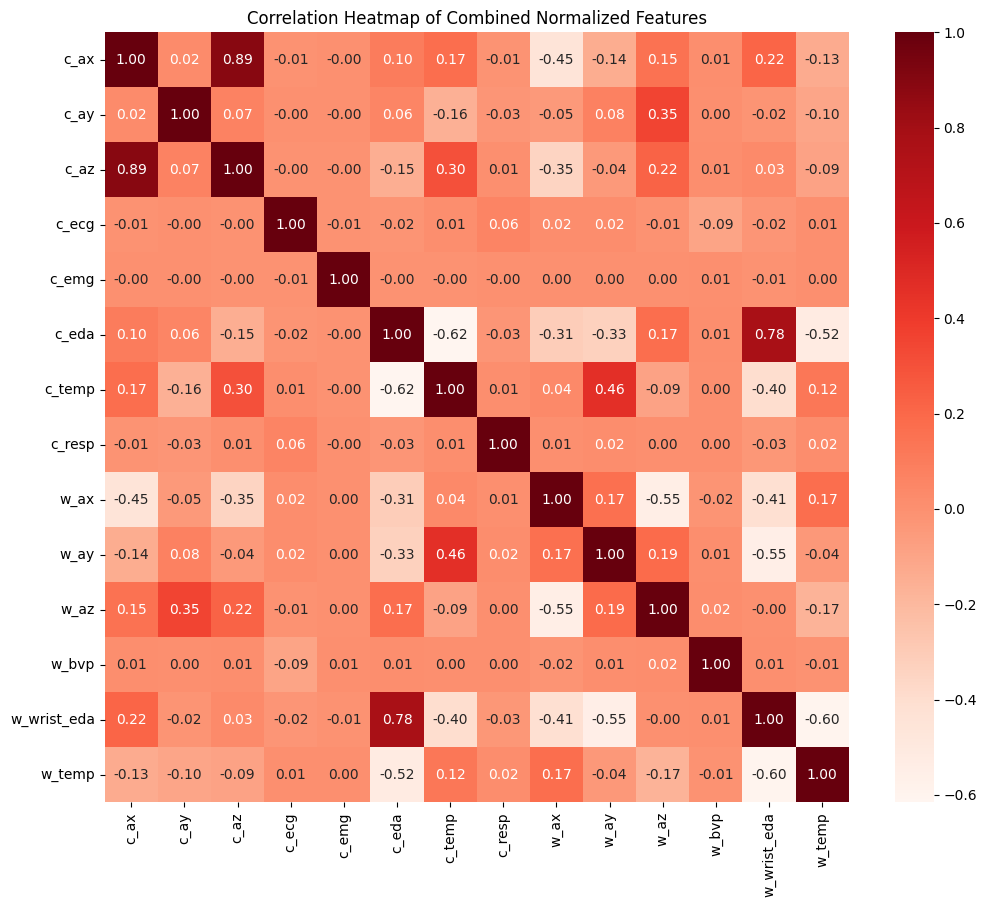

In [35]:
# --- Correlation Heatmap (Example on Combined Normalized Features) ---
if not X_norm_comb.empty:
    print("\n\n--- Correlation Heatmap for Combined Normalized Features ---")
    try:
        plt.figure(figsize=(12, 10))
        # Ensure X_norm_comb has data
        if not X_norm_comb.empty:
            cor = X_norm_comb.corr()
            sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, fmt=".2f")
            plt.title("Correlation Heatmap of Combined Normalized Features")
            plt.show()
        else:
            print("No data to plot correlation heatmap.")
    except Exception as e:
        print(f"Could not plot correlation heatmap: {e}")

In [36]:
# --- OLS P-values (Example on Combined Normalized Features) ---
# Note: statsmodels OLS is typically for regression. For feature significance in classification,
# other methods (like feature importances from tree models, or coefficients from logistic regression)
# are often preferred. This is kept from your original code for consistency.
if not X_norm_comb.empty and not y_norm_comb.empty:
    print("\n\n--- OLS P-values for Combined Normalized Features (Interpret with caution for classification) ---")
    try:
        # Ensure X_norm_comb and y_norm_comb are not empty and have compatible indices
        common_index = X_norm_comb.index.intersection(y_norm_comb.index)
        if not common_index.empty:
            X_ols = sm.add_constant(X_norm_comb.loc[common_index])
            y_ols = y_norm_comb.loc[common_index]
            
            # OLS might struggle with perfect multicollinearity if features are highly correlated.
            # Check for and remove constant columns in X_ols if any (add_constant adds one already)
            X_ols = X_ols.loc[:, X_ols.nunique() > 1]

            if X_ols.shape[1] > 0 : # Check if there are any non-constant columns left
                model_ols = sm.OLS(y_ols.astype(float), X_ols.astype(float)).fit() # Ensure float types
                print(model_ols.pvalues)
            else:
                print("No valid features for OLS after removing constant columns.")
        else:
            print("No common indices between features and labels for OLS.")
    except Exception as e:
        print(f"OLS P-values calculation failed: {e}")




--- OLS P-values for Combined Normalized Features (Interpret with caution for classification) ---
c_ax            0.000000e+00
c_ay           3.066149e-157
c_az            0.000000e+00
c_ecg           2.937018e-03
c_emg           4.961464e-05
c_eda           0.000000e+00
c_temp          0.000000e+00
c_resp         1.746480e-178
w_ax            0.000000e+00
w_ay            0.000000e+00
w_az            0.000000e+00
w_bvp           3.852943e-01
w_wrist_eda     0.000000e+00
w_temp         1.161276e-115
dtype: float64
